<a href="https://colab.research.google.com/github/Zekiye-Y/capstone-project/blob/main/Capstone_Project_kits23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Links
- https://keras.io/examples/vision/3D_image_classification/
- https://developer.nvidia.com/blog/building-medical-3d-image-segmentation-using-jupyter-notebooks-from-the-ngc-catalog/

# SETUP
## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Necessary Modules

In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.8 MB/s eta 0:00:00


In [6]:
import os
import cv2

import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf

## Unzip Kits23-Sample from Google Drive

In [ ]:
!unzip '/content/drive/MyDrive/kits23-sample.zip' -d '/content/drive/MyDrive/'

## Rename Case Numbers for Downstream Processing
Here I have to remove the '0's from the cases as it causes issues in the DataGenerator below. Freddy

In [33]:
def remove_zeros_from_folder_names():
    current_directory = "/content/drive/MyDrive/kits23-sample/dataset/"
    folder_names = os.listdir(current_directory)

    for folder_name in folder_names:
        if folder_name == "case_":
          new_folder_name = "case_0"
          old_path = os.path.join(current_directory, folder_name)
          new_path = os.path.join(current_directory, new_folder_name)
          os.rename(old_path, new_path)
        if folder_name == "case_00000":
          new_folder_name = "case_0"
          old_path = os.path.join(current_directory, folder_name)
          new_path = os.path.join(current_directory, new_folder_name)
          os.rename(old_path, new_path)
        else:
          new_folder_name = folder_name.replace('0', '')
        if new_folder_name != folder_name:
            old_path = os.path.join(current_directory, folder_name)
            new_path = os.path.join(current_directory, new_folder_name)
            os.rename(old_path, new_path)
            print(f"Renamed '{folder_name}' to '{new_folder_name}'")

remove_zeros_from_folder_names()

## View Image Instance
Note: the `visualize.py` script in conjunction with `util.py` will return a series of .png images in your chosen directory. The images will have the segmentation overlayed. I will need to work out a way to remove the segmentation so we can train on the images alone and with the segmentation as the ground-truth. Please see below for an example.

We might be able to modify the `visualize.py` file to just return a series of images without segmentation. In addition, we might be able to change the plane ('axial', saggital, 'coronal').Freddy


---



 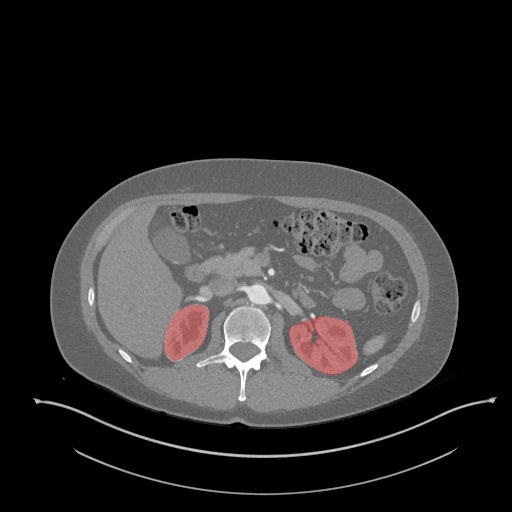

In [ ]:
!python visualize.py -c case_0 -d "/content/drive/MyDrive/kits23-sample/dataset/case_0/png_axial_view"

/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:81: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  vol = vol.get_data()
/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:82: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  seg = seg.get_data()


## Loading of Data
With thanks to the following Kaggle notebook which has given us a leg up at extracting the .nii.gz files into a training format for the model: https://www.kaggle.com/code/sowmyasamantula/3d-mri-brain-tumor-segmentation-u-net. Freddy

In [7]:
TRAIN_DATASET_PATH = "/content/drive/MyDrive/kits23-sample/dataset"

In [34]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [35]:
print(f"Number of Training Cases: {len(train_ids)}")
print(f"Number of Validation Cases: {len(val_ids)}")
print(f"Number of Testing Cases: {len(test_ids)}")

Number of Training Cases: 26
Number of Validation Cases: 8
Number of Testing Cases: 5


In [36]:
print(train_ids)
print(val_ids)
print(test_ids)

['case_28', 'case_29', 'case_8', 'case_583', 'case_11', 'case_2', 'case_581', 'case_9', 'case_13', 'case_587', 'case_585', 'case_23', 'case_6', 'case_26', 'case_22', 'case_15', 'case_3', '.ipynb_checkpoints', 'case_7', 'case_4', 'case_58', 'case_24', 'case_19', 'case_12', 'case_579', 'case_14']
['case_17', 'case_27', 'case_582', 'case_588', 'case_21', 'case_16', 'case_1', 'case_0']
['case_5', 'case_584', 'case_25', 'case_586', 'case_18']


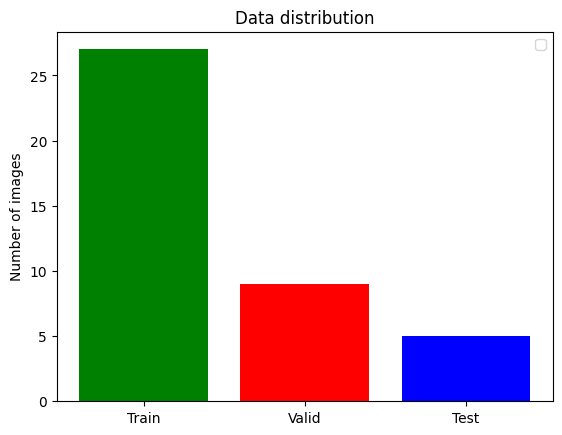

In [18]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

## Construction of DataGenerator

In [37]:
IMG_SIZE = 128
VOLUME_SLICES = 350
VOLUME_START_AT = 85

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    # I'm assumming because we have a single grayscale CT scan, n_channels = 1
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 4, n_channels = 1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        # I believe there's only three classes = 1. kidney, 2. tumour, 3. cyst
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 3))


        # Generate data
        for c, i in enumerate(Batch_ids):
            data_path = os.path.join(TRAIN_DATASET_PATH, f'case_{c}/imaging.nii.gz');
            image = nib.load(data_path).get_fdata()

            data_path = os.path.join(TRAIN_DATASET_PATH, f'case_{c}/segmentation.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # NOT SURE WHAT THIS CODE IS FOR!!
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 3);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [38]:
print("Training Gen Length:", training_generator.__len__())
print("Validation Gen Length:", valid_generator.__len__())
print("Testing Gen Length:", test_generator.__len__())

Training Gen Length: 6
Validation Gen Length: 2
Testing Gen Length: 1


In [39]:
counter = 0

print("\n-- TRAINING DATA -- ")
for x,y in training_generator.__iter__():
  if counter == 1:
    break
  print(type(x))
  print(f"Shape X: ({len(x)}, {len(x[0]), len(x[1]), len(x[2]), len(x[3])})")
  print(f"Shape Y: ({y.shape}\n")
  counter += 1


-- TRAINING DATA -- 


ValueError: ignored